In [13]:
from pocket_cube.cube import Cube
from pocket_cube.cube import Move
from heapq import heappop, heappush
from tests import *
import matplotlib.pyplot as plt
import numpy as np
import numpy
from random import choice
from typing import Dict, List, Tuple

%matplotlib ipympl

In [231]:
CONST = 8
def heuristic(cube: Cube) -> int:
    sum = 0

    for i, x in enumerate(cube.state):
        if x != cube.goal_state[i]:
            sum += 1
    # return sum
    # if sum == 0:
    #     return 0
    # if sum < 4:
    #     return 3
    # if sum == 8:
    #     return 1
    # return int(sum // 4)
    # return int(sum // 5)
    # return int(sum // 6.1) if sum < 16 else int(sum // 1.75) # BEST
    # return int(sum // 5.5) if sum < 16 else int(sum // 1.75) # BEST
    return int(sum // 5) if sum < 15 else int(sum // 1.7) # ABSOLUTE BEST
    # return int(sum // 8) if sum < 16 else int(sum // 1.75)
    # return int(sum // 6) if sum < 17 else int(sum // 3)
    # return int(sum // 5.4) if sum < 17 else int(sum // 3)
    # return int(sum // 5)
    # return int(sum // 5.4)
    # return int(sum // 5.5)

In [214]:
cube = Cube(scrambled=False)

cube = cube.move(Move.F)
cube =cube.move(Move.R)
cube =cube.move(Move.U)
cube =cube.move(Move.Fp)
cube =cube.move(Move.U)
cube =cube.move(Move.Fp)
cube =cube.move(Move.Up)
cube =cube.move(Move.F)
cube =cube.move(Move.R)
heuristic(cube)

9

In [ ]:

positions = {
    0: (0, 1),
    1: (1, 1),
    2: (0, 0),
    3: (1, 0),
    4: (0 + 2, 1),
    5: (1 + 2, 1),
    6: (0 + 2, 0),
    7: (1 + 2, 0),
    8: (0 + 4, 1),
    9: (1 + 4, 1),
    10: (0 + 4, 0),
    11: (1 + 4, 0),
    12: (0 - 2, 1),
    13: (1 - 2, 1),
    14: (0 - 2, 0),
    15: (1 - 2, 0),
    16: (0, 1 + 2),
    17: (1, 1 + 2),
    18: (0, 0 + 2),
    19: (1, 0 + 2),
    20: (0, 1 - 2),
    21: (1, 1 - 2),
    22: (0, 0 - 2),
    23: (1, 0 - 2),
}

def distance_heuristic(cube: Cube) -> int:
    base_coords = np.array([(0, 1), (1, 1), (0, 0), (1, 0)])
    offsets = np.array([[0, 0], [1, 0], [2, 0], [-1, 0], [0, 1], [0, -1]]) * 2

    idx = 0
    sum = 0
    for i, x in enumerate(cube.state):
        if x != cube.goal_state[i]:
            idx = 4 * x
            while cube.state[idx] != cube.goal_state[idx + 1]:
                idx+=1
            p1 = positions[4 * x]
            p2 = positions[idx]
            sum += abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    return sum


In [54]:
def construct_road_astar(cube: Cube, road: Dict[str, Tuple[Cube, int, Move]]) -> List:
    p, _, m = road[cube.hash()]
    path = []
    while m:
        path.append(m)
        p, _, m = road[p.hash()]
    path.reverse()
    return path

def astar(cube: Cube, h) -> List:
    # Coada de prioritati: (COST, HASH, CUBE)
    frontier = []
    heappush(frontier, (0 + h(cube), cube.hash(), cube.clone()))
    # Nodurile descoperite ca dictionar nod -> (parinte, cost)
    # discovered = {cube.hash(): (None, 0)}
    # Drumul ca dictionar  nod -> (parinte, cost, mutare)
    road = {cube.hash(): (None, 0, None)}

    curr_cube: Cube
    while frontier:
        _, _, curr_cube = heappop(frontier)
        c = road[curr_cube.hash()][1]
        if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
            return construct_road_astar(curr_cube, road)
        for m in Move:
            tentative_cube = curr_cube.move(m)
            tentative_cube_hash = tentative_cube.hash()
            tentative = h(tentative_cube)

            if tentative_cube_hash not in road:
                heappush(frontier, (c + 1 + tentative, tentative_cube_hash, tentative_cube))
                road[tentative_cube_hash] = (curr_cube, c + 1, m)

    return None

In [239]:
# Run A*
input = Cube(case3)
reconstruct = input.clone()
path = astar(input, heuristic)

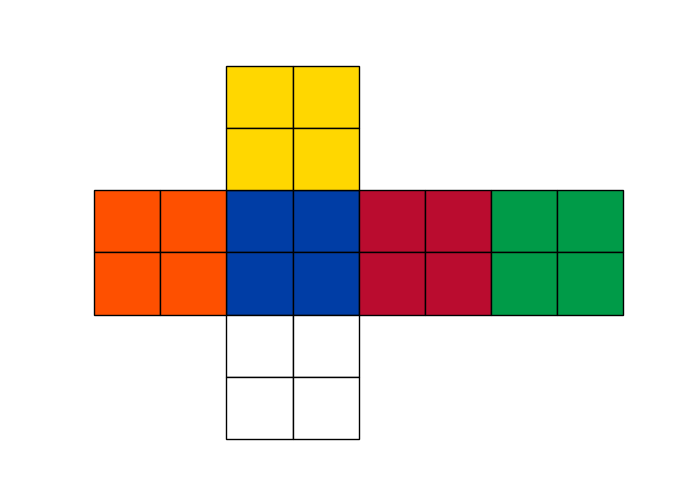

In [240]:
# Verify A*
assert path is not None
for m in path:
    reconstruct = reconstruct.move(m)
plt.close("all")
reconstruct.render()

assert numpy.array_equal(reconstruct.state, input.goal_state)

In [44]:
def construct_road_bfs(
    common_state: Cube,
    road_to_common_state: Dict[str, Tuple[Cube, Move]],
    road_to_end: Dict[str, Tuple[Cube, Move]],
) -> List:
    # Create the road from input to common state
    p1, m1 = road_to_common_state[common_state.hash()]
    road = []
    while m1:
        road.append(m1)
        p1, m1 = road_to_common_state[p1.hash()]
    road.reverse()

    # Create the road from common state to input
    p2, m2 = road_to_end[common_state.hash()]
    road_rev = []
    while m2:
        road_rev.append(m2.opposite())
        p2, m2 = road_to_end[p2.hash()]

    return road + road_rev


def bfs_bidirectional(cube: Cube) -> List:
    curr_cube: Cube
    curr_cube_reversed: Cube

    direction = 1
    cube = cube.clone()
    queue = [cube]
    discovered = {cube.hash(): (0, cube)}
    road = {cube.hash(): (None, None)}

    cube_reversed = cube.clone()
    aux = cube_reversed.state
    cube_reversed.state = cube_reversed.goal_state
    cube_reversed.goal_state = aux
    queue_reverse = [cube_reversed]

    discovered_reversed = {cube_reversed.hash(): (0, cube_reversed)}
    reversed_road = {cube_reversed.hash(): (None, None)}

    while queue and queue_reverse:
        if direction:
            curr_cube = queue.pop(0)

            if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
                return curr_cube, curr_cube_reversed, road, reversed_road

            _, common_cube = discovered_reversed.get(cube.hash(), (0, None))
            c, _ = discovered[curr_cube.hash()]

            if common_cube:
                return construct_road_bfs(common_cube, road, reversed_road)

            for m in Move:
                tentative_cube = curr_cube.move(m)
                tentative_cube_hash = tentative_cube.hash()
                if discovered.get(tentative_cube_hash, None) is None:
                    queue.append(tentative_cube)
                    discovered[tentative_cube_hash] = (c + 1, tentative_cube)
                    road[tentative_cube_hash] = (curr_cube, m)
        else:
            curr_cube_reversed = queue_reverse.pop(0)
            # curr_cube_reversed.render()
            # print(curr_cube_reversed.state)
            # print(curr_cube_reversed.goal_state)
            if numpy.array_equal(
                curr_cube_reversed.state, curr_cube_reversed.goal_state
            ):
                return curr_cube, curr_cube_reversed, road, reversed_road

            _, common_cube = discovered.get(curr_cube_reversed.hash(), (False, None))
            c, _ = discovered_reversed[curr_cube_reversed.hash()]

            if common_cube:
                return construct_road_bfs(common_cube, road, reversed_road)

            for m in Move:
                tentative_cube = curr_cube_reversed.move(m)
                tentative_cube.goal_state = curr_cube_reversed.goal_state
                tentative_cube_hash = tentative_cube.hash()
                if discovered_reversed.get(tentative_cube_hash, None) is None:
                    queue_reverse.append(tentative_cube)
                    discovered_reversed[tentative_cube_hash] = (c + 1, tentative_cube)
                    reversed_road[tentative_cube_hash] = (curr_cube_reversed, m)

        direction = direction ^ 1

In [124]:
input = Cube(case4)
road = bfs_bidirectional(input)

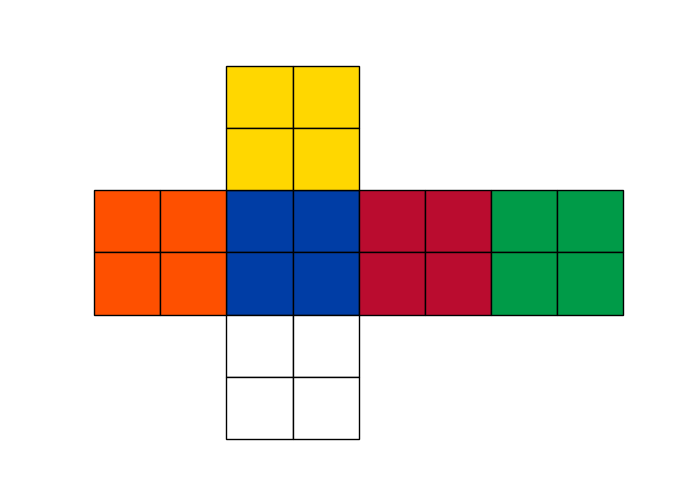

In [125]:
# Verify BFS

# Test road from input to end
reconstruct = input.clone()
for m in road:
    reconstruct = reconstruct.move(m)
plt.close("all")
reconstruct.render()

assert numpy.array_equal(reconstruct.state, input.goal_state)


In [244]:
CONST = 8
def another_heuristic(cube: Cube) -> int:
    sum = 0

    for i, x in enumerate(cube.state):
        if x != cube.goal_state[i]:
            sum += 1
    # return sum
    # if sum == 0:
    #     return 0
    # if sum < 4:
    #     return 3
    # if sum == 8:
    #     return 1
    return int(sum // 1.7)
    # return int(sum // 5)
    # return int(sum // 6.1) if sum < 16 else int(sum // 1.75) # BEST
    # return int(sum // 5.5) if sum < 16 else int(sum // 1.75) # BEST
    # return int(sum // 5) if sum < 15 else int(sum // 1.7) # ABSOLUTE BEST
    # return int(sum // 8) if sum < 16 else int(sum // 1.75)
    # return int(sum // 6) if sum < 17 else int(sum // 3)
    # return int(sum // 5.4) if sum < 17 else int(sum // 3)
    # return int(sum // 5)
    # return int(sum // 5.4)
    # return int(sum // 5.5)

In [241]:
from math import log, sqrt

class Node:
    def __init__(self, cube: Cube, parent=None, parent_action=None):
        self.cube = cube
        self.state = cube.state
        self.goal_state = cube.goal_state
        self.parent = parent
        self.parent_action = parent_action
        self.children = []
        self._number_of_visits = 0
        self._rewards = 0
        self._untried_actions = list(Move)
        self._tried_actions = []
        return

    def is_fully_expanded(self):
        # Check if all possible moves have been tried
        return len(self._untried_actions) == 0

    def is_final(self):
        return numpy.array_equal(self.state, self.goal_state)

def select_move(
    node: Node,
    c,
) -> Node:
    max = 0
    result = None
    child: Node
    for child in node.children:

        parent: Node = child.parent
        # print(f"Child Q {child._rewards}")
        # print(f"Child N {child._number_of_visits}")
        # print(f"Parent Q {parent._rewards}")
        # print(f"Parent Q {parent._number_of_visits}")
        ucb = child._rewards / child._number_of_visits + c * sqrt(
            log(parent._number_of_visits) / child._number_of_visits
        )
        if ucb > max:
            max = ucb
            result = child

    return result


def get_available_actions(cube: Cube, discovered):
    return [i for i in Move if cube.move(i).hash() not in discovered]

def print_tree(tree: Node, indent = 0):
    if not tree:
        return
    tab = "".join(" " * indent)
    print("%sN = %d, Q = %d" % (tab, tree._number_of_visits, tree._rewards))
    for a in tree.children:
        print("%s %d ==> " % (tab, a._number_of_visits))
        print_tree(a, indent + 3)

def monte_carlo(cube: Cube, budget: int, C: float, h) -> Cube:
    # DACĂ există un arbore construit anterior ȘI
    #   acesta are un copil ce corespunde ultimei acțiuni a adversarului,
    # ATUNCI acel copil va deveni nodul de început pentru algoritm.
    # ALTFEL, arborele de start este un nod gol, corespunzator adversarului (eu sunt la mutare si urmeaza
    # sa creez un nod copil al nodului radacina).

    # {'N': 7, 'Q': 2.5, 'parent': None, 'actions': {0: {'N': 3, ...}, 1: {'N': 4, ...}}}

    # ---------------------------------------------------------------


    tree = Node(cube)
    discovered = {cube.hash(): True}
    print(budget)
    print(C)
    for _ in range(budget):
        # Punctul de start al simulării va fi rădăcina de start
        node = tree
        # TODO <4>
        # Coborâm în arbore până când ajungem la o stare finală
        # sau la un nod cu acțiuni neexplorate.
        # Variabilele state și node se 'mută' împreună.

        while not node.is_final() and node.is_fully_expanded():
            node = select_move(node, C)

        if node.is_final():
            return node.cube
        # ---------------------------------------------------------------
        if not node.is_final():
            move = np.random.choice(node._untried_actions)
            new_cube = node.cube.move(move)

            node._untried_actions.remove(move)
            node._tried_actions.append(move)
            # while new_cube.hash() in discovered and node._untried_actions:
            #     move = np.random.choice(node._untried_actions)
            #     new_cube = node.cube.move(move)

            #     node._untried_actions.remove(move)
            #     node._tried_actions.append(move)
            # discovered[node.cube.hash()] = True
            child = Node(new_cube, node, move)
            node.children.append(child)
            node = child


        # ---------------------------------------------------------------

        # TODO <6>
        # Se simulează o desfășurare a jocului până la ajungerea într-o
        # starea finală. Se evaluează recompensa în acea stare.\
        timeout = 14

        curr_cube = node.cube
        while not numpy.array_equal(curr_cube.state, curr_cube.goal_state) and timeout > 0:
            moves = list(Move)
            # new_moves = [m for m in moves if not discovered.get(curr_cube.move(m).hash(), False)]
            # if not new_moves:
            #     break
            curr_cube = curr_cube.move(choice(moves))
            timeout -= 1

        if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
            reward = 24
            return curr_cube
        else:
            reward = 24 - h(curr_cube)
        # ---------------------------------------------------------------

        while node is not None:
            node._number_of_visits += 1
            node._rewards += reward
            node = node.parent
        # ---------------------------------------------------------------

    return cube

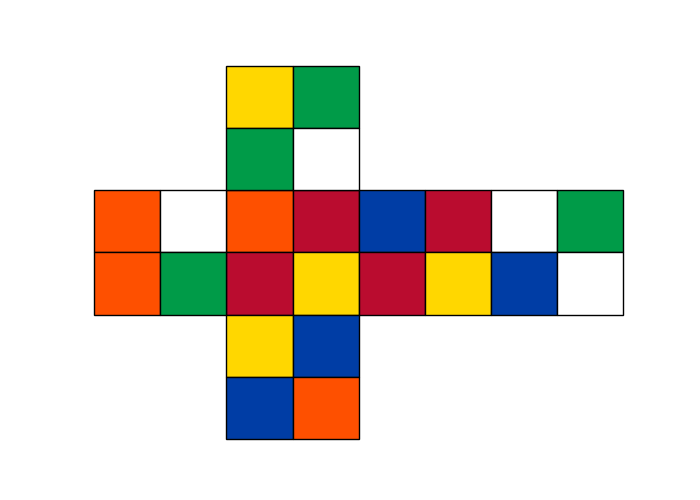

20000
0.1


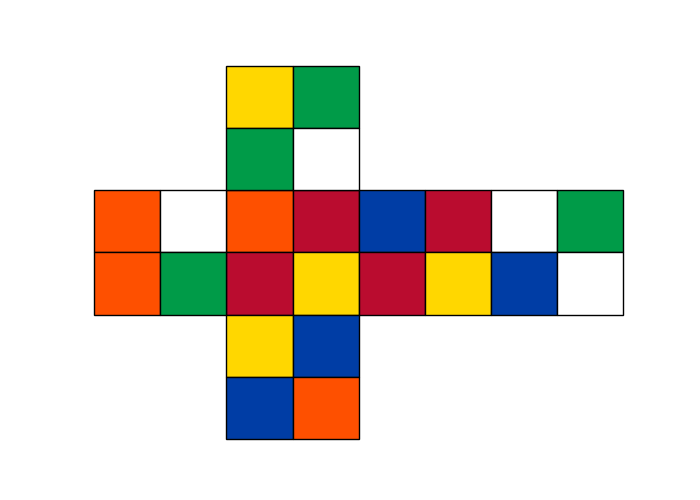

In [251]:
input = Cube(scrambled=False)
plt.close("all")

# input = input.move(Move.R)
# input = input.move(Move.Up)
# input = input.move(Move.Rp)
# input = input.move(Move.Fp)
# input = input.move(Move.U)
input = Cube(case3)
input.render()
monte_carlo(input, 20000, 0.1, another_heuristic).render()

In [133]:
def create_pattern_database():
    PATTERN_DATABASE = {}
    cube = Cube(scrambled=False)
    PATTERN_DATABASE[cube.hash()] = 0

    queue = [cube]
    for distance in range(1, 8):
        for _ in range(6 ** (distance - 1)):
            init = queue.pop(0)
            for m in Move:
                new_cube = init.move(m)
                queue.append(new_cube)
                if new_cube.hash() not in PATTERN_DATABASE:
                    PATTERN_DATABASE[new_cube.hash()] = distance
    return PATTERN_DATABASE

In [134]:
PATTERN_DATABASE = create_pattern_database()

In [82]:
def new_heuristic(cube: Cube):
    return PATTERN_DATABASE.get(cube.hash(), heuristic(cube))

In [91]:
# Test pattern database

ALL_MOVES = list(Move)

def test_new_heuristic(moves):
    # Since we are using random moves, we might end up with a sequence
    # That could be solved in less moves
    assert new_heuristic(Cube(moves)) <= len(moves)

for _ in range(10):
    for distance in range(1, 8):
        moves = [choice(ALL_MOVES) for _ in range(distance)]
        test_new_heuristic(moves)

# Some static test cases
assert new_heuristic(Cube('R U')) == 2
assert new_heuristic(Cube('R U R')) == 3
assert new_heuristic(Cube('R U F R U')) == 5

In [159]:
# Run A* with PATTERN heuristic
input = Cube(case1)
path = astar(input, new_heuristic)

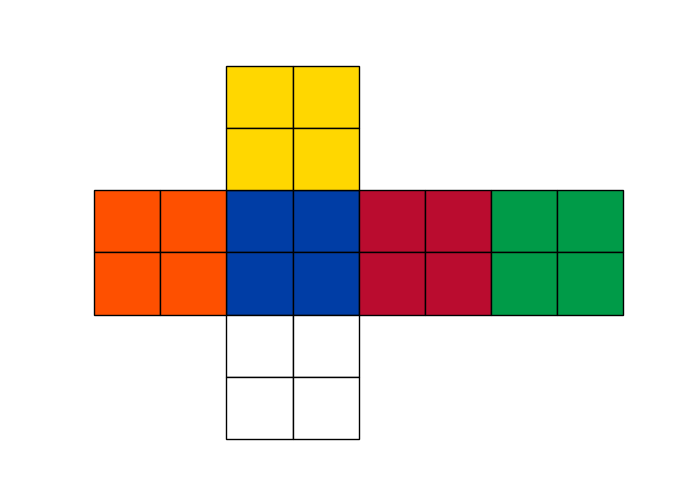

In [160]:
reconstruct = input.clone()
for m in path:
    reconstruct = reconstruct.move(m)

plt.close("all")
reconstruct.render()
assert numpy.array_equal(reconstruct.state, input.goal_state)

In [149]:
# input = Cube(scrambled=False)
plt.close("all")

# input = input.move(Move.R)
# input = input.move(Move.Up)
# input = input.move(Move.Rp)
# input = input.move(Move.Fp)
# input = input.move(Move.U)
input = Cube(case4)
monte_carlo(input, 20000, 0.1, new_heuristic).render()

NameError: name 'monte_carlo' is not defined